In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")

In [3]:
import data_handling as dh
import subsampling as ss
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS

from cli import get_file_paths
import plotting
import pipeline

In [4]:
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['data_resolution_in_min'] = f'30'
data_params['plotting_resolution_in_min'] = '30'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

# for site_key in FREQ_GROUPS.keys():
site_key = 'Central'
# for type_key in FREQ_GROUPS[site_key].keys():
type_key = 'HF1'
print(site_key, type_key)

data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key

file_paths = get_file_paths(data_params)

Central HF1


In [5]:
activity_dets_arr = pd.DataFrame()

for dc_tag in data_params['dc_tags']:
    location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
    dc_dets = dh.construct_activity_arr_from_location_summary(location_df, dc_tag, file_paths, data_params)
    dc_dets = dc_dets.set_index("Date_and_Time_UTC")
    activity_dets_arr = pd.concat([activity_dets_arr, dc_dets], axis=1)

In [6]:
def construct_activity_arr_from_location_summary(location_df, dc_tag, file_paths, data_params):
    """
    Construct an activity summary for each date and time's number of detected calls. Only looking from 03:00 to 13:00 UTC.
    Will be used later to assembled an activity summary for each duty-cycling scheme to compare effects.
    """
    location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
    location_df.insert(0, 'call_durations', (location_df['call_end_time'] - location_df['call_start_time']))
    df_resampled_every_30 = location_df.resample(f"{data_params['data_resolution_in_min']}T", on='ref_time', origin='start')
    shortest_call_per_30 = pd.to_numeric(df_resampled_every_30['call_durations'].min())/1e6
    shortest_call_per_30.index = shortest_call_per_30.index.floor('30T')
    max_allowable_calls_per_30 = np.abs(((int(data_params['data_resolution_in_min'])*60*60) / shortest_call_per_30))
    num_of_detections = df_resampled_every_30['ref_time'].count()
    num_of_detections.index = num_of_detections.index.floor('30T')
    test_number_of_detections_less_than_max_per_30(num_of_detections, max_allowable_calls_per_30)

    all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('*.csv')))))
    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)
    col_name = f"Number_of_Detections ({dc_tag})"
    incomplete_activity_arr = pd.DataFrame(num_of_detections.values, index=num_of_detections.index, columns=[col_name])
    activity_arr = incomplete_activity_arr.reindex(index=all_processed_datetimes, fill_value=0)
    activity_arr = activity_arr.resample(f"{data_params['data_resolution_in_min']}T", origin='start').first()
    activity_arr = activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["Date_and_Time_UTC", col_name])

def test_number_of_detections_less_than_max_per_30(num_of_detections, max_allowable_calls_per_30):
    assertion = (num_of_detections <= max_allowable_calls_per_30).values
    assert(not(False in assertion))

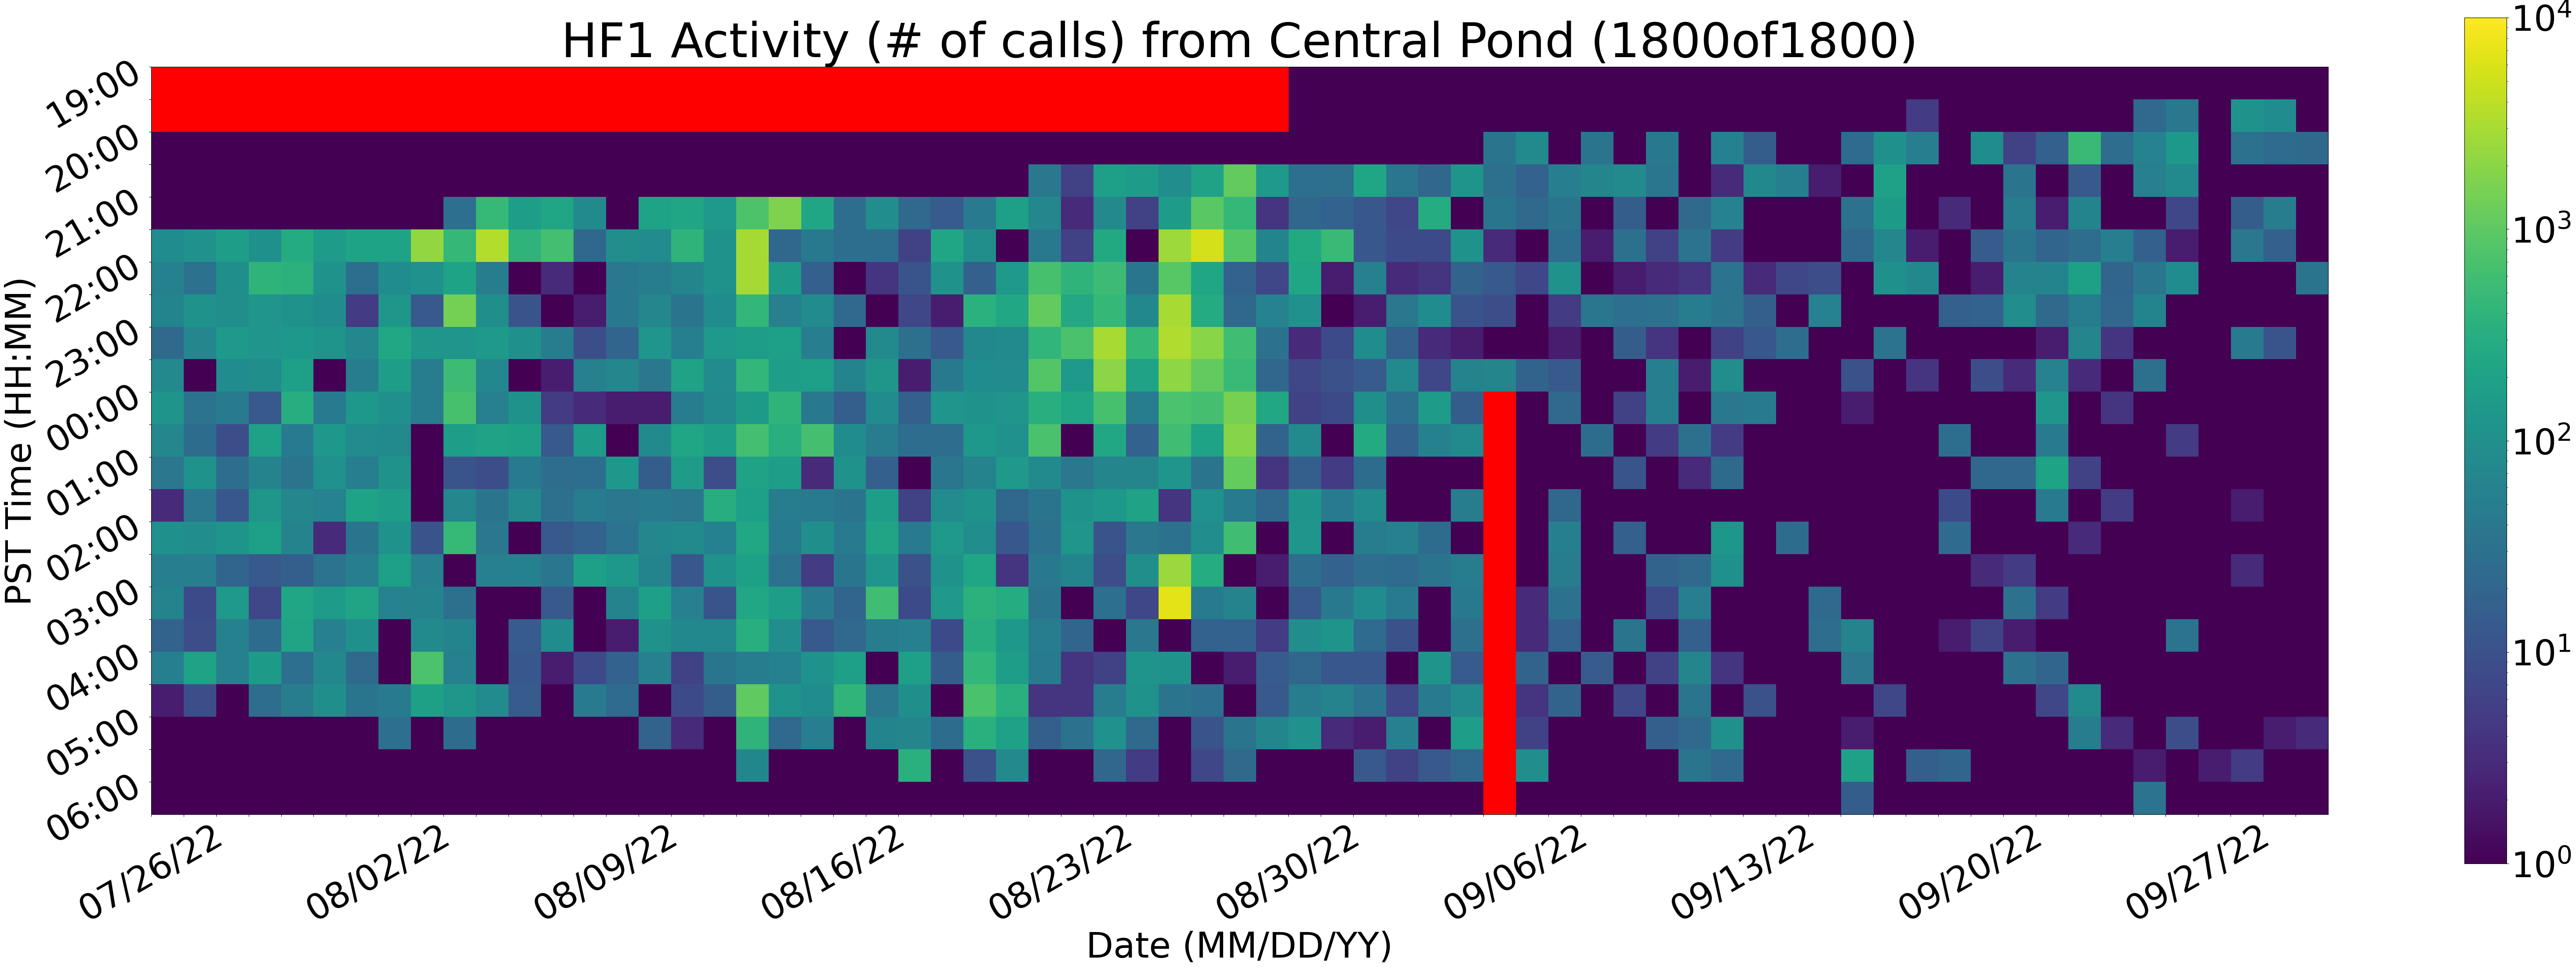

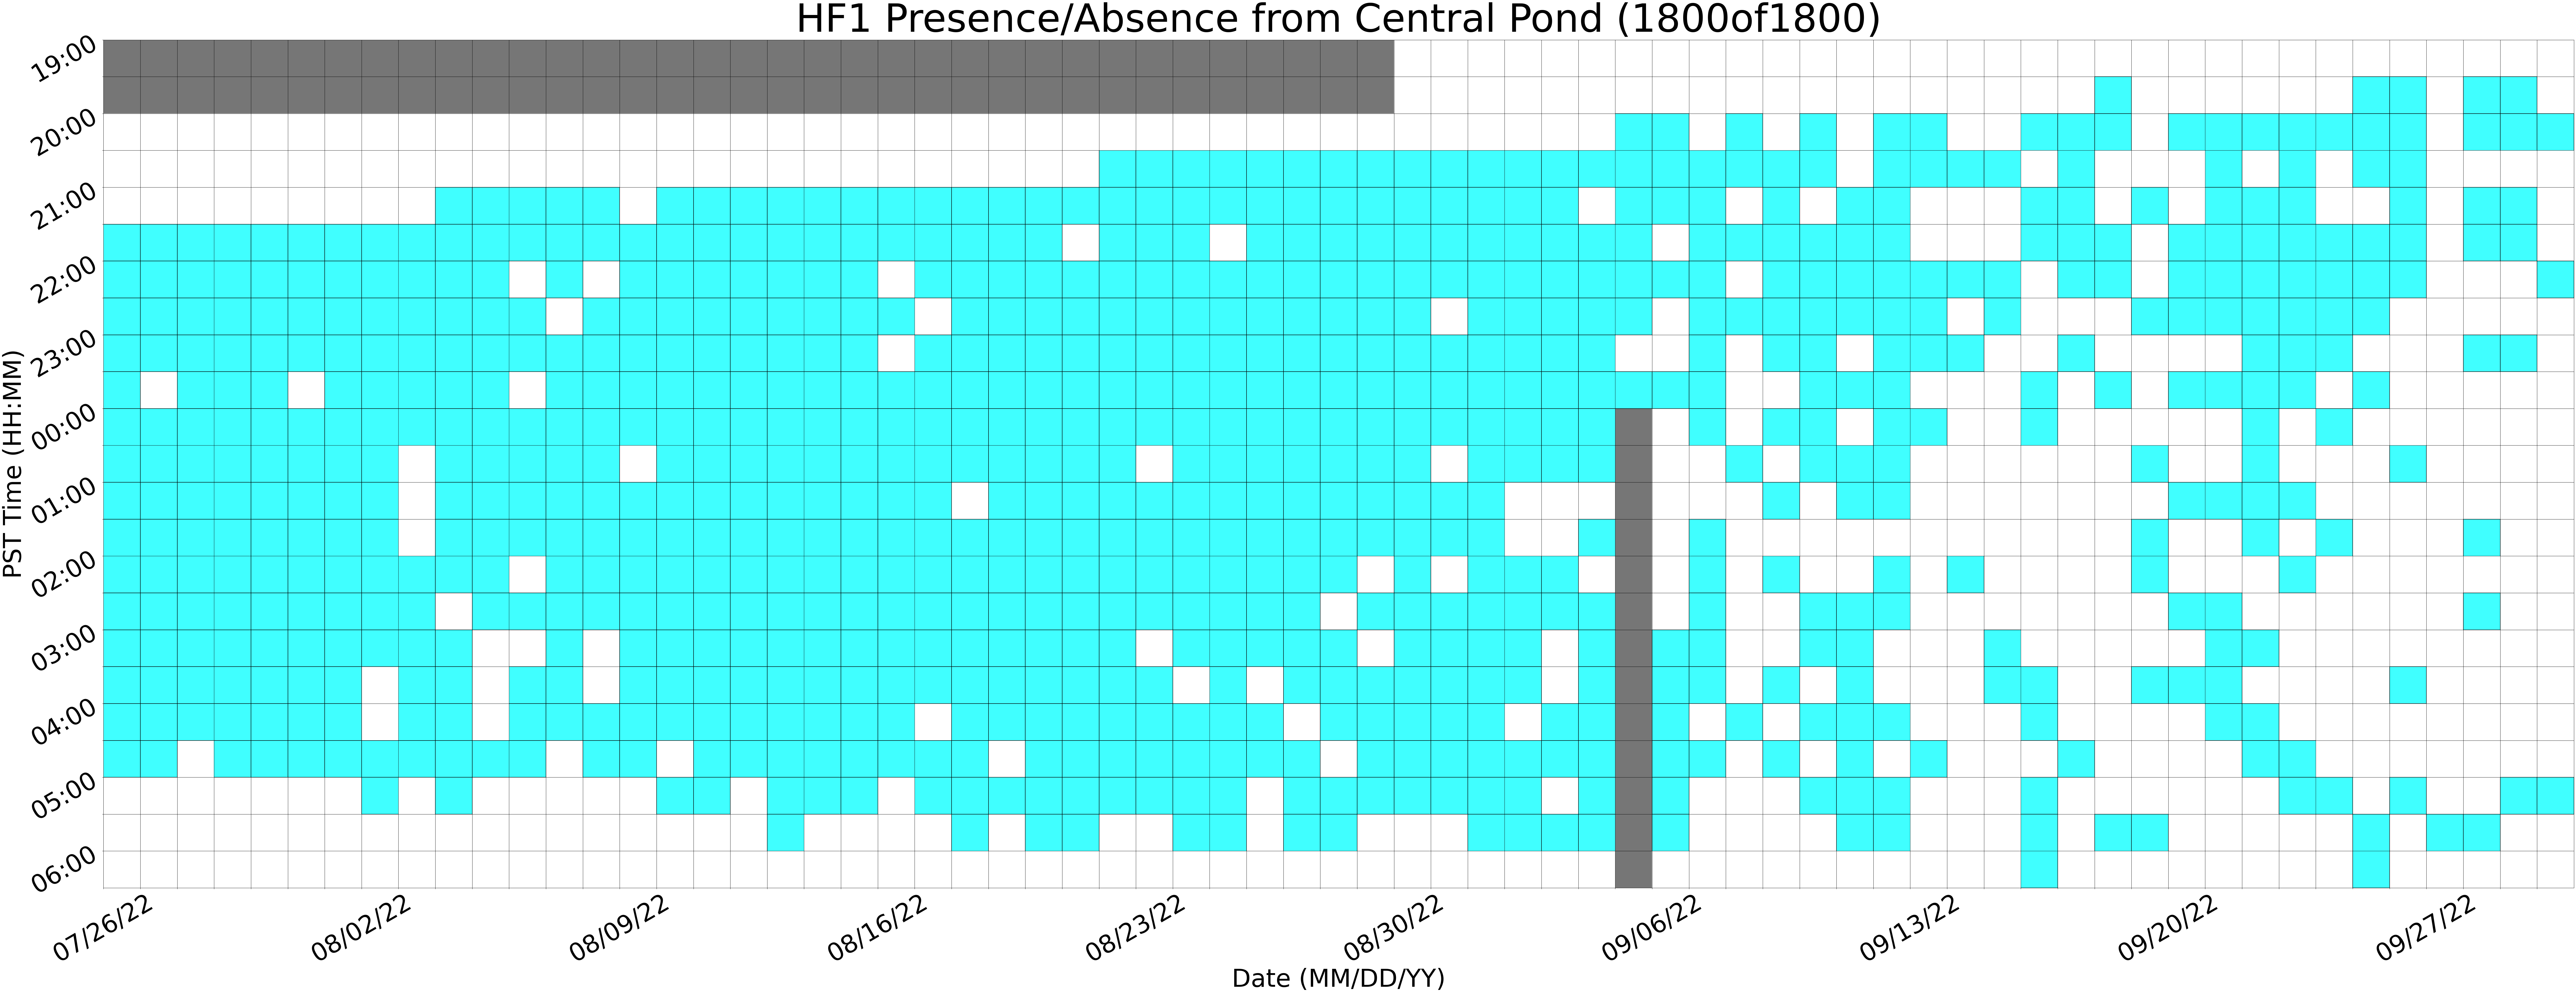

In [7]:
plotting.plot_activity_grid_for_dets(activity_dets_arr, data_params, pipeline_params, file_paths)
plotting.plot_presence_grid(activity_dets_arr, data_params, pipeline_params, file_paths)
plotting.plot_dc_det_activity_comparisons_per_scheme(activity_dets_arr, data_params, pipeline_params, file_paths)
plotting.plot_dc_presence_comparisons_per_scheme(activity_dets_arr, data_params, pipeline_params, file_paths)